In [1]:
import math
import xml.etree.ElementTree as etree
import random
import pprint

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
class Point:
    def __init__(self):
        self.x = None
        self.y = None
        self.z = None

        self.id = None

In [4]:


pp = pprint.PrettyPrinter(indent=4)

def Distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2

    dx = x1 - x2
    dy = y1 - y2
    
    return(math.sqrt(dx * dx + dy * dy))

def ClosestPoint(all_points, new_point):
    best_point = None
    best_distance = None

    for current_point in all_points:
        current_distance = Distance(new_point, current_point)
        if best_distance == None or current_distance < best_distance:
            best_distance = current_distance
            best_point = current_point
    
    return best_point

k = 2 
def BuildKdtree(points, depth=0):
    n = len(points)

    if n<= 0:
        return None
    
    axis = depth % k

    sorted_points = sorted(points, key= lambda point: point[axis])

    return({
        "point": sorted_points[ (int)(n / 2)][:k],
        "left":  BuildKdtree(sorted_points[:(int)(n/2)], depth+1),
        "right": BuildKdtree(sorted_points[(int)(n/2) + 1:], depth+1),
        "classified": -1
    })

def KdtreeNaiveClosestPoint( root, point, depth=0, best=None):
    if root is None:
        return best
    
    axis = depth % k
 
    next_best = None
    next_branch = None
    if best is None or Distance(point, best) > Distance(point, root["point"]):
        next_best = root["point"]
    else:
        next_best = best
    
    if point[axis] < root["point"][axis]:
        next_branch = root["left"]
    else:
        next_branch = root["right"]
    
    return(KdtreeNaiveClosestPoint(next_branch, point, depth+1, best = next_best))

def CloserDistance( pivot, p1, p2):
    if p1 is None:
        return(p2)
    if p2 is None:
        return(p1)
    
    d1 = Distance(p1, pivot)
    d2 = Distance(p2, pivot)
    
    if d1 < d2:
        return(p1)
    else:
        return(p2)

def KdtreeClosestPoint( root, point, depth=0):
    if root is None:
        return (None)
    
    axis = depth % k 
    next_branch = None
    opposite_branch = None

    if point[axis] < root["point"][axis]:
        next_branch = root["left"]
        opposite_branch = root["right"]
    else:
        next_branch = root["right"]
        opposite_branch = root["left"]
    
    #print("depth:",depth, " p1:", point)
    
    best = CloserDistance(point,
                        KdtreeClosestPoint(next_branch, point, depth + 1),
                        root["point"])

    if Distance(point, best) > abs(point[axis] - root["point"][axis]):
        best = CloserDistance(point,
                                KdtreeClosestPoint(opposite_branch, point, depth+1),
                                best)

    return(best)


def KdtreeRangeSearch( root, point, depth=0, epsilon=1.0):

    fig,ax = plt.subplots()

    if root is None:
        return(None)
    
    
    axis = depth % k
    next_branch = None
    opposite_branch = None
    
    points = []
    
    if root["classified"] == -1 and Distance(point, root["point"]) <= epsilon:
        #print("Member")
        points.append(root["point"])
    
    if point[axis] < root["point"][axis]:
        next_branch = root["left"]
        opposite_branch = root["right"]
    else:
        next_branch = root["right"]
        opposite_branch = root["left"]


    #print("Depth>>", depth)
    #if root["right"] is not None:
    ##    print("right>>", root["right"]["point"])
    #if root["left"] is not None:
    #    print("left>>", root["left"]["point"])
    #if next_branch is not None:
    #    print("Next>>", next_branch["point"])


    
    # 近い側のブランチの探索
    #print("Near Branch")
    new_points = KdtreeRangeSearch( next_branch, point, depth + 1, epsilon)
    for p in points:
        ax.scatter(p[0], p[1], c= "black", s=5)

    if new_points is not None:
        for p in new_points:
            ax.scatter(p[0], p[1], c= "blue", s=5)
        points.extend(new_points)

    # 遠い側のブランチの探索
    #print("Opposite Branch")
    if opposite_branch is not None:
        if math.fabs(point[axis] - root["point"][axis]) <= epsilon:
            new_points = KdtreeRangeSearch( opposite_branch, point, depth + 1, epsilon)

            if new_points is not None:
                for p in new_points:
                    ax.scatter(p[0], p[1], c= "red", s=5)
                points.extend(new_points)
    

    return(points)
    


In [5]:
class RayCasting:
    def __init__(self, range_min_th, range_max_th, range_resolution, angle_min, angle_max, angle_resolution):

                         
        self.__lookuptable  =   None
        self.ray_line_num     =   None
        self.single_ray_point_num     = None

        self.__range_max_th = None
        self.__range_min_th = None
        self.__range_res    = None

        self.__angle_max    = None
        self.__angle_min    = None
        self.__angle_res    = None
        
        self.ChangeRangeParam( range_min_th, range_max_th, range_resolution)
        self.ChangeAngleParam( angle_min, angle_max, angle_resolution)
        
        self.CreateLookUpTable()
        

    def ChangeRangeParam(self, range_min_th, range_max_th, range_resolution):
        self.__range_min_th = range_min_th
        self.__range_max_th = range_max_th
        self.__range_res    = range_resolution

        print("Range Param")
        print(self.__range_min_th, self.__range_max_th, self.__range_res)
        
    def ChangeAngleParam(self, angle_min, angle_max, angle_resolution):
        deg2rad = 1.0
        if angle_min > 1.57 or angle_max > 1.57:
            deg2rad = math.pi / 180.0

        self.__angle_min    = deg2rad * angle_min
        self.__angle_max    = deg2rad * angle_max
        self.__angle_res    = deg2rad * angle_resolution
        print("Angle Param")
        print(self.__angle_min, self.__angle_max, self.__angle_res)
        
        
    def CreateLookUpTable(self):
        print("Angle Param")
        print(self.__angle_min, self.__angle_max, self.__angle_res)
        print("Range Param")
        print(self.__range_min_th, self.__range_max_th, self.__range_res)
        
        self.ray_line_num            = (int) ( (self.__angle_max - self.__angle_min) / self.__angle_res )
        self.single_ray_point_num    = (int) ( (self.__range_max_th - self.__range_min_th) / self.__range_res)

        #line = [[ 0.0, 0.0, 0.0] for i in range(self.single_ray_point_num)]
        point_range = self.__range_min_th
        p = [ 0.0, 0.0, 0.0]
        
        range_list = []
        self.single_ray_point_num = 0
        while point_range < self.__range_max_th:
            #p[0] = point_range 
            #p[2] = point_range * math.tan(self.__angle_res * 0.5)
            range_list.append([point_range, point_range * math.tan(self.__angle_res * 0.5)])
            point_range += point_range * math.tan( self.__angle_res)
            self.single_ray_point_num += 1
        
        #for i in range(self.single_ray_point_num):
        #    point_range = self.__range_min_th + self.__range_res * i
        #    line[i][2] = point_range * math.tan(self.__angle_res * 0.5)

        #self.__lookuptable = [line for i in range(self.ray_line_num)]


        point_range = None
        self.__lookuptable = []
        for i in range(self.ray_line_num):
            ang = self.__angle_min + self.__angle_res * i
            line = []
            #for j in range(self.single_ray_point_num):
            for j in range(len(range_list)):
                #point_range = self.__range_min_th + self.__range_res * j
                #point_range = l[j][0]
                #l[j][0] = point_range * math.cos(ang)
                #l[j][1] = point_range * math.sin(ang)
                p = []
                x = range_list[j][0] * math.cos(ang)
                y = range_list[j][0] * math.sin(ang)
                p = [ x, y, range_list[j][1]]
                line.append( p )
                #self.__lookuptable[i][j][0] = point_range * math.cos(ang)
                #self.__lookuptable[i][j][1] = point_range * math.sin(ang)
                #self.__lookuptable[i][j][2] = point_range * math.tan(self.__angle_res * 0.5)
                #print( point_range, ":", self.__lookuptable[i][j][2])
            self.__lookuptable.append(line)

        #for i in range(self.ray_line_num):
        #    for j in range(len(self.__lookuptable[i])):
        #        print(self.__lookuptable[i][j])
        
    def Run( self, kdtree):
        nearest_points = []
        for i in range(self.ray_line_num):
            p = None
            for j in range(self.single_ray_point_num):
                p = KdtreeClosestPoint( kdtree,  self.__lookuptable[i][j][:2], 0)
                dist = Distance( self.__lookuptable[i][j][:2], p)
                #print(i,",",j,",",self.__lookuptable[i][j], ":::: dist=",dist)
                
                if dist < self.__lookuptable[i][j][2]:
                    nearest_points.append(p)
            if p == None:
                nearest_points.append(self.__lookuptable[i][self.range_ray_point_num - 1][:2])
        return(nearest_points)

In [6]:


points = [[random.uniform(0,100), random.uniform(-50,50), i] for i in range(100)]

#points[5][0] = points[6][0]
#points[7][1] = points[8][1]


In [7]:
kdtree = BuildKdtree(points, 0)

In [8]:
math.tan(0.5 * math.pi / 180.0) * 50

0.43634338953793944

In [9]:
ray_cast = RayCasting( 5, 100, 1, -90, 90, 0.5)

Range Param
5 100 1
Angle Param
-1.5707963267948966 1.5707963267948966 0.008726646259971648
Angle Param
-1.5707963267948966 1.5707963267948966 0.008726646259971648
Range Param
5 100 1


In [10]:
nn_points = ray_cast.Run(kdtree)

In [11]:
nn_points

[[0.5682700706516441, -6.7589244907020785],
 [8.00848405170237, -35.96749180023792],
 [14.512585457988491, -33.619629568962274],
 [11.562641414243046, -24.734851014852634],
 [21.998919487962066, -44.45278584439226],
 [34.189696823194616, -47.020466429176544],
 [33.69841726077708, -34.7465880265662],
 [46.111717327758775, -44.85806470488693],
 [51.96253617656447, -47.3608396476478],
 [24.167369820008823, -21.409298684467338],
 [64.25323981997066, -49.12708166848665],
 [41.37572787854407, -30.22966640231858],
 [43.48139741863915, -27.87614483126587],
 [27.819869930851514, -16.715675674077644],
 [78.16829365367495, -44.984477999262865],
 [34.329829703814916, -17.846423443724632],
 [63.13368463002668, -33.05595645765198],
 [83.92099652914929, -42.507919294863704],
 [81.7647809096559, -39.97554483965959],
 [46.971019097196056, -21.70933060443009],
 [63.579951844525255, -28.457982795282],
 [69.67399297419796, -30.975364532910188],
 [73.19748754428673, -29.701576623217118],
 [39.7622937828764

In [12]:
import time

C:\Users\km70553\AppData\Local\Temp\ipykernel_17508\2229216722.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots()


0.3650219440460205


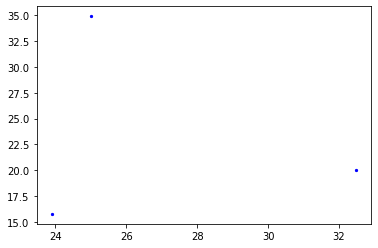

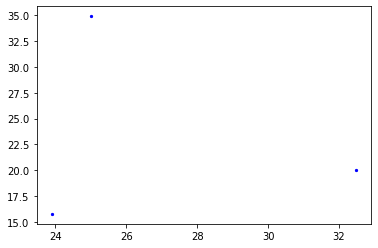

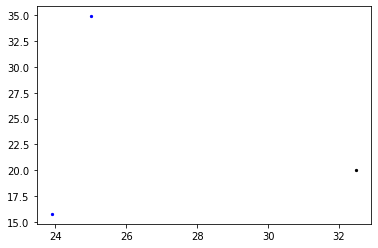

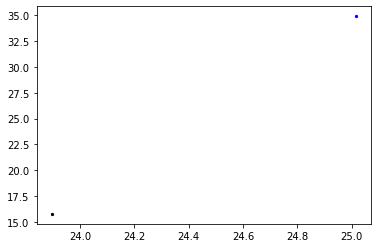

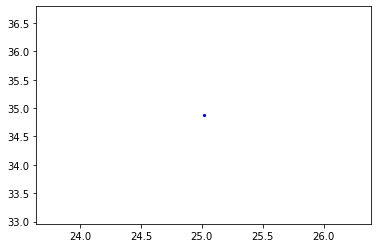

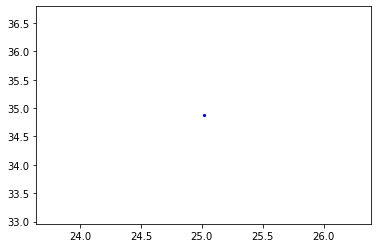

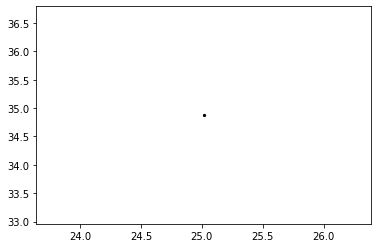

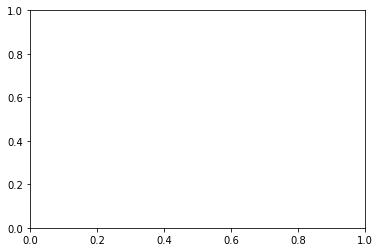

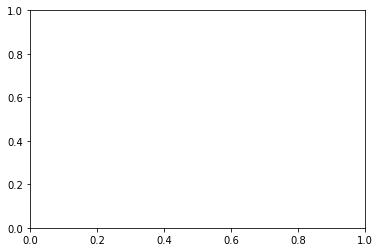

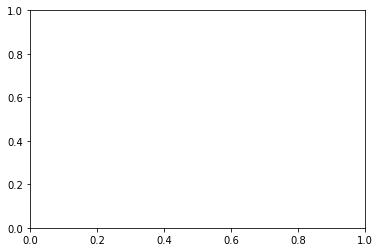

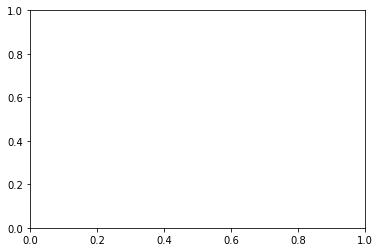

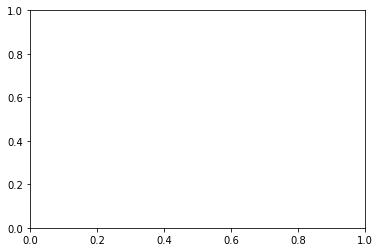

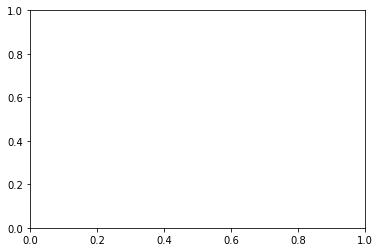

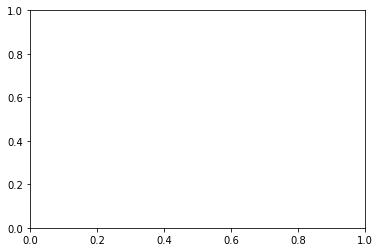

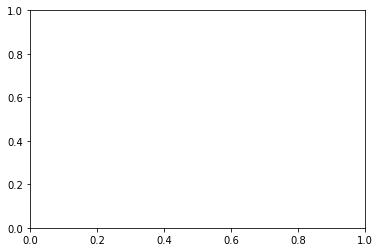

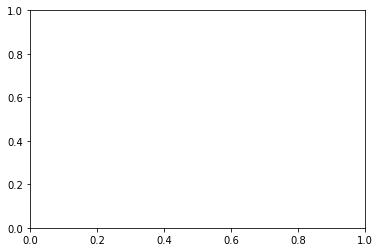

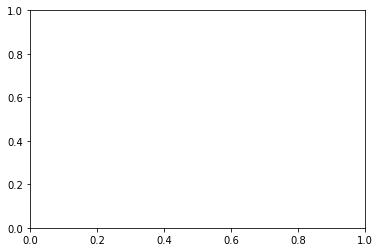

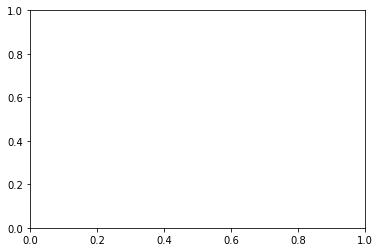

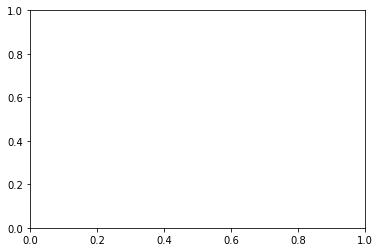

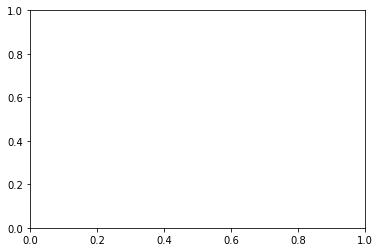

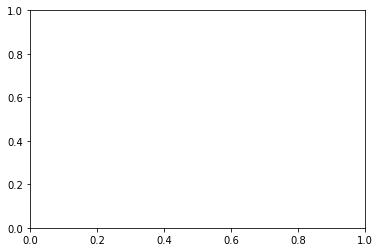

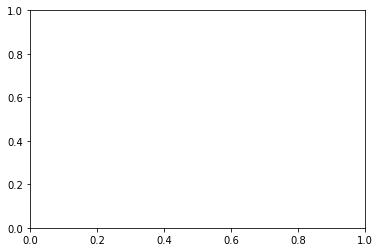

In [13]:
#pp.pprint(kdtree)
p = [ 25, 25]
#nearest = kdtree_naive_closest_point(kdtree, p)

#nearest = KdTreeClosestPoint(kdtree, p)
#nearest
epsilon = 10
t1 = time.time()
cluster_points = KdtreeRangeSearch(kdtree, p, 0, epsilon=epsilon)
t2 = time.time()
print(t2-t1)

In [14]:
len(cluster_points)

3

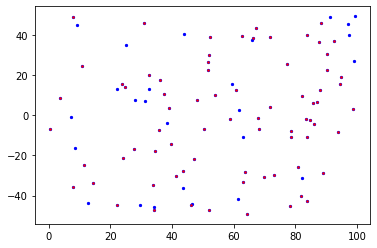

In [15]:
fig = plt.figure()
ax = plt.axes()

#tree = kdtree
#depth = 0

    


for point in points:
    ax.scatter(point[0], point[1], c= "blue", s=5)

for point in nn_points:
    ax.scatter(point[0], point[1], c="red", s=2)


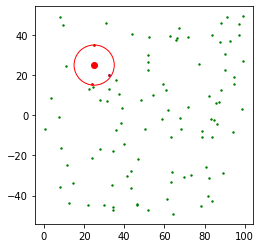

In [16]:

nearest = KdtreeClosestPoint(kdtree, p)
nearest

fig = plt.figure()
ax = plt.axes()
ax.set_aspect("equal")
for point in points:
    ax.scatter(point[0], point[1], c="green", s=2)
ax.scatter(p[0], p[1], c="red")
ax.scatter(nearest[0], nearest[1], c="blue", s=2)

for member in cluster_points:
    ax.scatter(member[0],member[1], c="red", s=2)
    #circle = patches.Ellipse(xy=(member[0], member[1]), width=5, height=5, ec="blue", fill=False)
    #ax.add_patch(circle)

eps = patches.Ellipse(xy=(p[0], p[1]), width = 2*epsilon, height=2*epsilon, ec="red", fill=False, linewidth=1)
ax.add_patch(eps)